In [1]:
import pandas as pd
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

In [2]:
train_df = pd.read_csv("./data/ratings_train.txt", sep = "\t")
test_df = pd.read_csv("./data/ratings_test.txt", sep = "\t")

In [3]:
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
# 결측치 확인
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [6]:
test_df.isna().sum()

id          0
document    3
label       0
dtype: int64

In [7]:
train_df = train_df.dropna(subset = ["document"])
test_df = test_df.dropna(subset = ["document"])

In [8]:
train_df.shape, test_df.shape

((149995, 3), (49997, 3))

In [9]:
# 종속변수 확인
np.unique(train_df["label"], return_counts = True)

(array([0, 1], dtype=int64), array([75170, 74825], dtype=int64))

In [10]:
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 데이터 전처리

In [11]:
# 한글 이외의 문자들 제거
train_df["document"] = train_df["document"].map(lambda x: re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "", x))
test_df["document"] = test_df["document"].map(lambda x: re.sub("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "", x))

In [12]:
train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [13]:
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [14]:
train_df = train_df[train_df["document"].map(lambda x: len(x.strip()) >= 1)]
test_df = test_df[test_df["document"].map(lambda x: len(x.strip()) >= 1)]

In [15]:
train_df.shape, test_df.shape

((148740, 3), (49575, 3))

In [16]:
# 중복 데이터 확인
train_df[train_df["document"].duplicated(keep = False)].sort_values("document")

,id,document,label
46599,9682597,그리고 내 감정을 불러 일으켰다,1
43436,9582856,그리고 내 감정을 불러 일으켰다,1
123713,9582855,그리고 내 감정을 불러 일으켰다,1
93364,171409,가입 추천바람,1
138373,171407,가입 추천바람,1
...,...,...,...
57831,3906478,흥미진진,1
8446,5158304,힐러리 더프의 매력에 빠지다,1
72688,5153363,힐러리 더프의 매력에 빠지다,1
26889,7971814,힘들다,0


In [17]:
# 중복제거
train_df = train_df.drop_duplicates(subset = ["document"], keep ="first")
test_df = test_df.drop_duplicates(subset = ["document"], keep ="first")

In [18]:
train_df.shape, test_df.shape

((143660, 3), (48403, 3))

# 토큰화

In [19]:
okt = Okt()

In [20]:
okt.morphs("아 더빙 진짜 짜증나네요 목소리", stem = False)

['아', '더빙', '진짜', '짜증나네요', '목소리']

In [21]:
okt.morphs("아 더빙 진짜 짜증나네요 목소리", stem = True)

['아', '더빙', '진짜', '짜증나다', '목소리']

In [22]:
okt.nouns("아 더빙 진짜 짜증나네요 목소리")

['더빙', '진짜', '목소리']

In [23]:
okt.pos("아 더빙 진짜 짜증나네요 목소리")

[('아', 'Exclamation'),
 ('더빙', 'Noun'),
 ('진짜', 'Noun'),
 ('짜증나네요', 'Adjective'),
 ('목소리', 'Noun')]

In [24]:
%%time
train_df["token"] = train_df["document"].map(lambda x: okt.morphs(x, stem = True))
test_df["token"] = test_df["document"].map(lambda x: okt.morphs(x, stem = True))

CPU times: total: 22min 43s
Wall time: 21min 58s


In [27]:
train_df.head(20)

,id,document,label,token
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너, 무재, 밓었, 다그, 래서, 보다, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직하다, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이, 몬페, 그, 의, 익살스럽다, 연기, 가, 돋보이다, 영화, 스파이더맨, ..."
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0,"[막, 걸음, 마, 떼다, 세, 부터, 초등학교, 학년, 생인, 살다, 영화, ㅋㅋ..."
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0,"[원작, 의, 긴장감, 을, 제대로, 살리다, 하다]"
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0,"[별, 반개, 도, 아깝다, 욕, 나오다, 이응경, 길용우, 연, 기, 생활, 이,..."
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1,"[액션, 이, 없다, 재미, 있다, 몇, 안되다, 영화]"
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1,"[왜케, 평점, 이, 낮다, 꽤, 볼, 만, 한, 데, 헐리우드, 식, 화려하다, ..."


In [26]:
train_df.to_csv("nsmc_ratings_train_pre.csv", index = False)
test_df.to_csv("nsmc_ratings_test_pre.csv", index = False)

In [29]:
type(train_df.loc[0, "token"])

list

- 위 타입이 문자열이라면 리스트로 바꾸는 법
    - train_df["token"] = train_df["token"].map(lambda x: eval(x))
    - test_df["token"] = test_df["token"].map(lambda x: eval(x))

In [30]:
train_df.shape, test_df.shape

((143660, 4), (48403, 4))

In [31]:
train_df["token"] = train_df["token"].map(lambda x: [i for i in x if len(i) > 1])
test_df["token"] = test_df["token"].map(lambda x: [i for i in x if len(i) > 1])

In [32]:
train_df.shape, test_df.shape

((143660, 4), (48403, 4))

In [33]:
train_df.head()

,id,document,label,token
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[포스터, 보고, 초딩, 영화, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[무재, 밓었, 다그, 래서, 보다, 추천]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 구먼, 솔직하다, 재미, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이, 몬페, 익살스럽다, 연기, 돋보이다, 영화, 스파이더맨, 에서, 늙다, 보..."


In [37]:
train_df = train_df[train_df["token"]. map(lambda x: len(x) > 0)]
test_df = test_df[test_df["token"]. map(lambda x: len(x) > 0)]

In [38]:
train_df.shape, test_df.shape

((143319, 4), (48260, 4))

# 정수인코딩

In [39]:
tokenizer = Tokenizer()

In [40]:
# 단어 집합 생성
# 등장 빈도 수가 높은 순서대로 정수값 부여
tokenizer.fit_on_texts(train_df["token"])

In [41]:
# 단어 집합
tokenizer.word_index

{'영화': 1,
 '보다': 2,
 '하다': 3,
 '없다': 4,
 '이다': 5,
 '있다': 6,
 '좋다': 7,
 '너무': 8,
 '정말': 9,
 '되다': 10,
 '재밌다': 11,
 '같다': 12,
 '진짜': 13,
 '으로': 14,
 '아니다': 15,
 '않다': 16,
 '에서': 17,
 '만들다': 18,
 '나오다': 19,
 '연기': 20,
 '평점': 21,
 '최고': 22,
 '스토리': 23,
 '생각': 24,
 '드라마': 25,
 '사람': 26,
 '감동': 27,
 '보고': 28,
 '이렇다': 29,
 '아깝다': 30,
 '배우': 31,
 'ㅋㅋ': 32,
 '감독': 33,
 '그냥': 34,
 '재미있다': 35,
 '재미': 36,
 '시간': 37,
 '내용': 38,
 '까지': 39,
 '주다': 40,
 '자다': 41,
 '하고': 42,
 '지루하다': 43,
 '재미없다': 44,
 '쓰레기': 45,
 '모르다': 46,
 '가다': 47,
 '들다': 48,
 '그렇다': 49,
 '싶다': 50,
 '작품': 51,
 '사랑': 52,
 '알다': 53,
 '하나': 54,
 '다시': 55,
 '마지막': 56,
 '정도': 57,
 '이건': 58,
 '오다': 59,
 '완전': 60,
 'ㅠㅠ': 61,
 '많다': 62,
 '처음': 63,
 'ㅋㅋㅋ': 64,
 '장면': 65,
 '액션': 66,
 '주인공': 67,
 '이렇게': 68,
 '안되다': 69,
 '차다': 70,
 '나다': 71,
 '이야기': 72,
 '지금': 73,
 '최악': 74,
 '넘다': 75,
 '느낌': 76,
 '연출': 77,
 'ㅡㅡ': 78,
 '인데': 79,
 '좋아하다': 80,
 '명작': 81,
 '그리고': 82,
 '받다': 83,
 '역시': 84,
 '별로': 85,
 '많이': 86,
 '남다': 87,
 '이해': 88,
 '이런': 89,
 '이영

In [42]:
# 단어 등장 수
tokenizer.word_counts

OrderedDict([('더빙', 572),
             ('진짜', 8288),
             ('짜증나다', 1002),
             ('목소리', 374),
             ('포스터', 572),
             ('보고', 4653),
             ('초딩', 422),
             ('영화', 50172),
             ('오버', 142),
             ('연기', 6326),
             ('조차', 242),
             ('가볍다', 360),
             ('않다', 7718),
             ('무재', 69),
             ('밓었', 1),
             ('다그', 75),
             ('래서', 20),
             ('보다', 40991),
             ('추천', 1180),
             ('교도소', 16),
             ('이야기', 2171),
             ('구먼', 11),
             ('솔직하다', 1199),
             ('재미', 3854),
             ('없다', 15519),
             ('평점', 6245),
             ('조정', 40),
             ('사이', 222),
             ('몬페', 2),
             ('익살스럽다', 9),
             ('돋보이다', 288),
             ('스파이더맨', 64),
             ('에서', 6979),
             ('늙다', 198),
             ('보이다', 1073),
             ('하다', 40759),
             ('커스틴', 4),
             (

In [43]:
total_cnt = len(tokenizer.word_index)
total_cnt

42120

- 사용 단어 수를 지정하여 토큰화
    - tokenizer = Tokenizer(num_words = 원하는 단어 수)
    - tokenizer.fit_on_texts(train_df["token"])

In [45]:
x_train = tokenizer.texts_to_sequences(train_df["token"])
x_test = tokenizer.texts_to_sequences(test_df["token"])

In [54]:
y_train = train_df["label"]
y_test = test_df["label"]

In [52]:
a = []
for i in range(len(x_train)):
    a.append(len(x_train[i]))
np.mean(a), np.median(a), np.max(a), np.min(a)

(9.029054068197517, 7.0, 67, 1)

In [55]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify = y_train, test_size = 0.2, random_state = 0)

In [56]:
train_seq = pad_sequences(x_train, maxlen = 9)
val_seq = pad_sequences(x_val, maxlen = 9)
test_seq = pad_sequences(x_test, maxlen = 9)

In [66]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1106, 60, input_shape = (9,)))
model.add(keras.layers.Dropout(0.4))

#model.add(keras.layers.LSTM(60, return_sequences = True, dropout = 0.4))
model.add(keras.layers.LSTM(60, dropout = 0.4))

model.add(keras.layers.Dense(1, activation = "sigmoid"))

In [67]:
adam = keras.optimizers.Adam(learning_rate =0.0005)
model.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)

In [68]:
history = model.fit(train_seq, y_train, batch_size = 64, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.5395 - loss: 0.6919 - val_accuracy: 0.6723 - val_loss: 0.6839
Epoch 2/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6614 - loss: 0.6743 - val_accuracy: 0.7166 - val_loss: 0.6147
Epoch 3/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6825 - loss: 0.6064 - val_accuracy: 0.7360 - val_loss: 0.5661
Epoch 4/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7087 - loss: 0.5697 - val_accuracy: 0.7539 - val_loss: 0.5365
Epoch 5/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7326 - loss: 0.5414 - val_accuracy: 0.7635 - val_loss: 0.5112
Epoch 6/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7505 - loss: 0.5161 - val_accuracy: 0.7708 - val_loss: 0.4914
Epoch 7/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7586 - loss: 0.4972 - val_accuracy: 0.7748 - val_loss: 0.4777
Epoch 8/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 

Epoch 50/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7933 - loss: 0.4315 - val_accuracy: 0.7925 - val_loss: 0.4352
Epoch 51/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7940 - loss: 0.4326 - val_accuracy: 0.7921 - val_loss: 0.4352
Epoch 52/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7934 - loss: 0.4333 - val_accuracy: 0.7899 - val_loss: 0.4355
Epoch 53/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7944 - loss: 0.4315 - val_accuracy: 0.7918 - val_loss: 0.4350
Epoch 54/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7949 - loss: 0.4308 - val_accuracy: 0.7918 - val_loss: 0.4351
Epoch 55/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7936 - loss: 0.4319 - val_accuracy: 0.7914 - val_loss: 0.4351
Epoch 56/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7943 - loss: 0.4313 - val_accuracy: 0.7928 - val_loss: 0.4348
Epoch 57/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - ac

Epoch 99/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7960 - loss: 0.4274 - val_accuracy: 0.7929 - val_loss: 0.4312
Epoch 100/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7966 - loss: 0.4236 - val_accuracy: 0.7934 - val_loss: 0.4311
Epoch 101/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7949 - loss: 0.4245 - val_accuracy: 0.7927 - val_loss: 0.4313
Epoch 102/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7953 - loss: 0.4270 - val_accuracy: 0.7935 - val_loss: 0.4308
Epoch 103/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7982 - loss: 0.4228 - val_accuracy: 0.7932 - val_loss: 0.4310
Epoch 104/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7971 - loss: 0.4245 - val_accuracy: 0.7935 - val_loss: 0.4312
Epoch 105/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7981 - loss: 0.4228 - val_accuracy: 0.7933 - val_loss: 0.4309
Epoch 106/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/st

3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8011 - loss: 0.4156 - val_accuracy: 0.7943 - val_loss: 0.4271
Epoch 148/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8017 - loss: 0.4179 - val_accuracy: 0.7943 - val_loss: 0.4274
Epoch 149/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8001 - loss: 0.4174 - val_accuracy: 0.7943 - val_loss: 0.4273
Epoch 150/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8001 - loss: 0.4160 - val_accuracy: 0.7940 - val_loss: 0.4270
Epoch 151/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8018 - loss: 0.4146 - val_accuracy: 0.7937 - val_loss: 0.4273
Epoch 152/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8004 - loss: 0.4158 - val_accuracy: 0.7948 - val_loss: 0.4268
Epoch 153/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8018 - loss: 0.4158 - val_accuracy: 0.7947 - val_loss: 0.4268
Epoch 154/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy:


KeyboardInterrupt



In [69]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [71]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1106, 60, input_shape = (9,)))
model.add(keras.layers.Dropout(0.4))

#model.add(keras.layers.LSTM(60, return_sequences = True, dropout = 0.4))
model.add(keras.layers.GRU(60, dropout = 0.4))

model.add(keras.layers.Dense(1, activation = "sigmoid"))

#adam = keras.optimizers.Adam(learning_rate =0.0005)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(train_seq, y_train, batch_size = 64, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7372 - loss: 0.5100 - val_accuracy: 0.7894 - val_loss: 0.4378
Epoch 2/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7863 - loss: 0.4409 - val_accuracy: 0.7914 - val_loss: 0.4277
Epoch 3/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7923 - loss: 0.4294 - val_accuracy: 0.7958 - val_loss: 0.4237
Epoch 4/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7977 - loss: 0.4214 - val_accuracy: 0.7964 - val_loss: 0.4199
Epoch 5/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7986 - loss: 0.4183 - val_accuracy: 0.7977 - val_loss: 0.4177
Epoch 6/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8026 - loss: 0.4105 - val_accuracy: 0.7987 - val_loss: 0.4164
Epoch 7/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8028 - loss: 0.4115 - val_accuracy: 0.7995 - val_loss: 0.4146
Epoch 8/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 

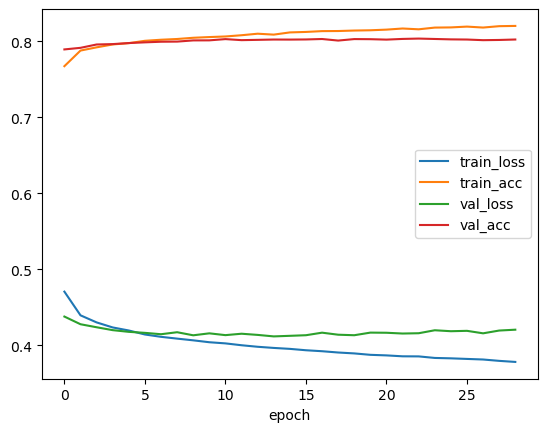

In [72]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

In [98]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1106, 60, input_shape = (9,)))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.GRU(60))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(30, activation = "relu"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

adam = keras.optimizers.Adam(learning_rate =0.0001)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(train_seq, y_train, batch_size = 32, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7482 - loss: 0.4972 - val_accuracy: 0.7897 - val_loss: 0.4300
Epoch 2/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7961 - loss: 0.4282 - val_accuracy: 0.7970 - val_loss: 0.4230
Epoch 3/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7998 - loss: 0.4170 - val_accuracy: 0.7984 - val_loss: 0.4176
Epoch 4/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8034 - loss: 0.4113 - val_accuracy: 0.8004 - val_loss: 0.4168
Epoch 5/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8057 - loss: 0.4031 - val_accuracy: 0.8009 - val_loss: 0.4147
Epoch 6/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8118 - loss: 0.3970 - val_accuracy: 0.8033 - val_loss: 0.4139
Epoch 7/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8169 - loss: 0.3906 - val_accuracy: 0.8029 - val_loss: 0.4179
Epoch 8/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 

In [99]:
model.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8060 - loss: 0.4044


[0.4123670160770416, 0.8034189939498901]

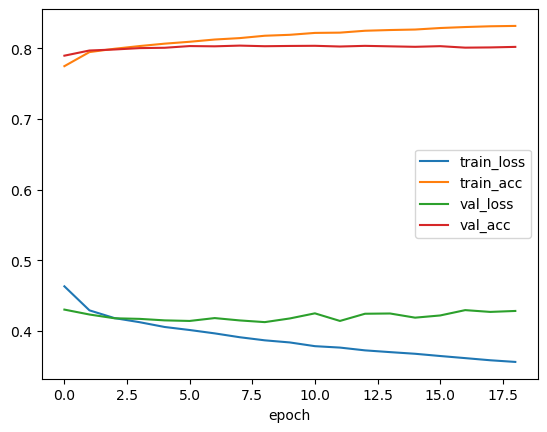

In [100]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

In [101]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1106, 60, input_shape = (9,)))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.GRU(60))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(10, activation = "relu"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

adam = keras.optimizers.Adam(learning_rate =0.0001)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(train_seq, y_train, batch_size = 16, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7450 - loss: 0.5050 - val_accuracy: 0.7914 - val_loss: 0.4306
Epoch 2/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7941 - loss: 0.4360 - val_accuracy: 0.7965 - val_loss: 0.4195
Epoch 3/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.8003 - loss: 0.4235 - val_accuracy: 0.7984 - val_loss: 0.4164
Epoch 4/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.8059 - loss: 0.4182 - val_accuracy: 0.7991 - val_loss: 0.4168
Epoch 5/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.8100 - loss: 0.4063 - val_accuracy: 0.8031 - val_loss: 0.4144
Epoch 6/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.8132 - loss: 0.4014 - val_accuracy: 0.8017 - val_loss: 0.4137
Epoch 7/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.8173 - loss: 0.3948 - val_accuracy: 0.8027 - val_loss: 0.4134
Epoch 8/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 

In [102]:
model.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8086 - loss: 0.4049


[0.41097480058670044, 0.8045172095298767]

In [107]:
train_seq = pad_sequences(x_train, maxlen = 8)
val_seq = pad_sequences(x_val, maxlen = 8)
test_seq = pad_sequences(x_test, maxlen = 8)

In [109]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1106, 45, input_shape = (9,)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.GRU(45))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(10, activation = "relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation = "sigmoid"))

adam = keras.optimizers.Adam(learning_rate =0.0001)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(train_seq, y_train, batch_size = 32, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7351 - loss: 0.5129 - val_accuracy: 0.7803 - val_loss: 0.4466
Epoch 2/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7834 - loss: 0.4455 - val_accuracy: 0.7892 - val_loss: 0.4305
Epoch 3/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7872 - loss: 0.4347 - val_accuracy: 0.7966 - val_loss: 0.4231
Epoch 4/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7969 - loss: 0.4229 - val_accuracy: 0.7916 - val_loss: 0.4231
Epoch 5/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8005 - loss: 0.4172 - val_accuracy: 0.7968 - val_loss: 0.4213
Epoch 6/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8064 - loss: 0.4106 - val_accuracy: 0.7972 - val_loss: 0.4207
Epoch 7/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.8069 - loss: 0.4076 - val_accuracy: 0.7986 - val_loss: 0.4179
Epoch 8/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 

In [110]:
model.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8058 - loss: 0.4088


[0.4155827760696411, 0.800745964050293]

In [115]:
train_seq = pad_sequences(x_train, maxlen = 13)
val_seq = pad_sequences(x_val, maxlen = 13)
test_seq = pad_sequences(x_test, maxlen = 13)

In [137]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1106, 256, input_shape = (13,)))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.LSTM(256, dropout = 0.4))

model.add(keras.layers.Dense(25, activation = "relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(train_seq, y_train, batch_size = 64, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.7506 - loss: 0.4904 - val_accuracy: 0.7970 - val_loss: 0.4254
Epoch 2/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8000 - loss: 0.4180 - val_accuracy: 0.8021 - val_loss: 0.4108
Epoch 3/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.8089 - loss: 0.3999 - val_accuracy: 0.8038 - val_loss: 0.4047
Epoch 4/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8126 - loss: 0.3927 - val_accuracy: 0.8075 - val_loss: 0.3986
Epoch 5/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.8201 - loss: 0.3806 - val_accuracy: 0.8100 - val_loss: 0.4015
Epoch 6/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8257 - loss: 0.3694 - val_accuracy: 0.8091 - val_loss: 0.4021
Epoch 7/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8277 - loss: 0.3649 - val_accuracy: 0.8083 - val_loss: 0.4017
Epoch 8/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - ac

In [138]:
model.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8115 - loss: 0.3935


[0.39975714683532715, 0.8090758323669434]

In [140]:
model = keras.Sequential()
model.add(keras.layers.Embedding(1106, 128, input_shape = (13,)))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.LSTM(256, dropout = 0.4))

model.add(keras.layers.Dense(10, activation = "relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(train_seq, y_train, batch_size = 64, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.7424 - loss: 0.4993 - val_accuracy: 0.7966 - val_loss: 0.4248
Epoch 2/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.7995 - loss: 0.4190 - val_accuracy: 0.8013 - val_loss: 0.4136
Epoch 3/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.8032 - loss: 0.4089 - val_accuracy: 0.8059 - val_loss: 0.4044
Epoch 4/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.8123 - loss: 0.3955 - val_accuracy: 0.8068 - val_loss: 0.4013
Epoch 5/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.8141 - loss: 0.3917 - val_accuracy: 0.8060 - val_loss: 0.4003
Epoch 6/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.8179 - loss: 0.3842 - val_accuracy: 0.8069 - val_loss: 0.3994
Epoch 7/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.8229 - loss: 0.3761 - val_accuracy: 0.8087 - val_loss: 0.4006
Epoch 8/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - ac

In [141]:
model.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8152 - loss: 0.3905


[0.39767754077911377, 0.8120803833007812]

In [142]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(1106, 128, input_shape = (13,)))
model2.add(keras.layers.Dropout(0.3))

model2.add(keras.layers.LSTM(128, dropout = 0.4))

model2.add(keras.layers.Dense(10, activation = "relu"))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dense(1, activation = "sigmoid"))

model2.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history2 = model2.fit(train_seq, y_train, batch_size = 32, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.7466 - loss: 0.4965 - val_accuracy: 0.7971 - val_loss: 0.4230
Epoch 2/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.7951 - loss: 0.4261 - val_accuracy: 0.8008 - val_loss: 0.4103
Epoch 3/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8060 - loss: 0.4099 - val_accuracy: 0.8055 - val_loss: 0.4047
Epoch 4/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.8097 - loss: 0.4025 - val_accuracy: 0.8090 - val_loss: 0.4008
Epoch 5/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.8109 - loss: 0.3961 - val_accuracy: 0.8056 - val_loss: 0.4031
Epoch 6/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8168 - loss: 0.3894 - val_accuracy: 0.8085 - val_loss: 0.3998
Epoch 7/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8193 - loss: 0.3824 - val_accuracy: 0.8107 - val_loss: 0.4026
Epoch 8/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 

In [143]:
model2.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8117 - loss: 0.3935


[0.4004466235637665, 0.809179425239563]

In [145]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(1106, 128, input_shape = (13,)))
model3.add(keras.layers.Dropout(0.3))

model3.add(keras.layers.LSTM(256, dropout = 0.4))

model3.add(keras.layers.Dense(15, activation = "relu"))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dense(1, activation = "sigmoid"))


adam = keras.optimizers.Adam(learning_rate =0.0005)
model3.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history3 = model3.fit(train_seq, y_train, batch_size = 64, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.7332 - loss: 0.5106 - val_accuracy: 0.7891 - val_loss: 0.4343
Epoch 2/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.7937 - loss: 0.4316 - val_accuracy: 0.7905 - val_loss: 0.4292
Epoch 3/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8018 - loss: 0.4158 - val_accuracy: 0.7976 - val_loss: 0.4165
Epoch 4/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8049 - loss: 0.4090 - val_accuracy: 0.7991 - val_loss: 0.4140
Epoch 5/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.8108 - loss: 0.3972 - val_accuracy: 0.8066 - val_loss: 0.4016
Epoch 6/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.8127 - loss: 0.3935 - val_accuracy: 0.8069 - val_loss: 0.4037
Epoch 7/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.8193 - loss: 0.3841 - val_accuracy: 0.8092 - val_loss: 0.3999
Epoch 8/1000
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - ac

In [146]:
model3.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8133 - loss: 0.3928


[0.39994022250175476, 0.8106920719146729]

In [153]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(1106, 128, input_shape = (13,)))
model4.add(keras.layers.Dropout(0.5))

model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.GRU(64, dropout = 0.4))

model4.add(keras.layers.Dense(10, activation = "relu"))
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Dense(1, activation = "sigmoid"))


adam = keras.optimizers.Adam(learning_rate =0.0001)
model4.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history4 = model4.fit(train_seq, y_train, batch_size = 16, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.6214 - loss: 0.6498 - val_accuracy: 0.7875 - val_loss: 0.4436
Epoch 2/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.7702 - loss: 0.4744 - val_accuracy: 0.7939 - val_loss: 0.4284
Epoch 3/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.7809 - loss: 0.4568 - val_accuracy: 0.7964 - val_loss: 0.4247
Epoch 4/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.7870 - loss: 0.4428 - val_accuracy: 0.7996 - val_loss: 0.4188
Epoch 5/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.7910 - loss: 0.4388 - val_accuracy: 0.8000 - val_loss: 0.4211
Epoch 6/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.7940 - loss: 0.4361 - val_accuracy: 0.8015 - val_loss: 0.4173
Epoch 7/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.7980 - loss: 0.4284 - val_accuracy: 0.8014 - val_loss: 0.4159
Epoch 8/1000
7166/7166 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 

KeyboardInterrupt: 

In [ ]:
model4.evaluate(test_seq, y_test)

In [ ]:
train_seq = pad_sequences(x_train, maxlen = 15)
val_seq = pad_sequences(x_val, maxlen = 15)
test_seq = pad_sequences(x_test, maxlen = 15)

In [165]:
len(tokenizer.word_index)

42120

In [167]:
model5 = keras.Sequential()
model5.add(keras.layers.Embedding(2106, 128, input_shape = (13,)))
model5.add(keras.layers.Dropout(0.5))

model5.add(keras.layers.BatchNormalization())
model5.add(keras.layers.GRU(256, dropout = 0.4))

model5.add(keras.layers.Dense(10, activation = "relu"))
model5.add(keras.layers.BatchNormalization())
model5.add(keras.layers.Dense(1, activation = "sigmoid"))

rmsprop = keras.optimizers.RMSprop(learning_rate = 0.001)
model5.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history5 = model5.fit(train_seq, y_train, batch_size = 32, epochs = 1000,
                    validation_data = (val_seq, y_val), callbacks = [early_stopping_cb])

Epoch 1/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.7333 - loss: 0.5161 - val_accuracy: 0.8089 - val_loss: 0.4086
Epoch 2/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.8078 - loss: 0.4149 - val_accuracy: 0.8125 - val_loss: 0.4061
Epoch 3/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.8141 - loss: 0.4060 - val_accuracy: 0.8134 - val_loss: 0.4031
Epoch 4/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.8197 - loss: 0.3983 - val_accuracy: 0.8154 - val_loss: 0.3977
Epoch 5/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.8201 - loss: 0.3972 - val_accuracy: 0.8153 - val_loss: 0.4019
Epoch 6/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8187 - loss: 0.3987 - val_accuracy: 0.8178 - val_loss: 0.3948
Epoch 7/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8212 - loss: 0.3941 - val_accuracy: 0.8160 - val_loss: 0.4033
Epoch 8/1000
3583/3583 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - ac

In [168]:
model5.evaluate(test_seq, y_test)

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8187 - loss: 0.3899


[0.39400845766067505, 0.8174057006835938]